# Exploration.ipynb
## Author: Elliot Pallister

Notebook for exploration in the Pareto analysis project

In [ ]:
# Collecting necessary imports

# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Internal imports
from pareto.data_io import get_cache, get_session, get_unit_channels, get_spike_times, get_stimulus_presentations, get_units_by_area, get_trials
from pareto.preprocessing import make_psth_cube
from pareto.stats import visual_selectivity_filter, subtract_baseline, zscore
from pareto.plotting import plot_pop_mean, mean_variance_scatter

In [ ]:
# Importing the cache from AllenSDK
cache = get_cache()

# Using session ID 1044385384
session_id = 1044385384
session = get_session(session_id)

units = get_unit_channels(session)
trials = get_trials(session)
stimulus_presentations = get_stimulus_presentations(session)
spike_times = get_spike_times(session)

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Firstly, I want to filter my units based on:

1. Quality metrics (SNR, interspike interval violations and firing rate)
2. Area (starting with VISp)

In [ ]:
quality_unit_filter = ((units['snr'] >= 1) & (units['isi_violations'] < 1) & (units['firing_rate'] > 0.1))
quality_units = units.loc[quality_unit_filter].copy()

area_of_interest = ['VISp']
area_units = get_units_by_area(quality_units, area_of_interest)

print(f'Number of filtered units in {area_of_interest}: {area_units.shape[0]}')


Number of filtered units in ['VISp']: 84


Next, I want to find the stimulus onsets for the image with id: im036_r.

I will use these onsets to:

1. Statistically test the unit responses for selectivity to the image, calculating effect sizes and p values, using a Wilcoxon paired rank test
2. Update the area units dataframe to contain effect sizes and p values in a column
3. Filter the area units by selectivity for the stimulus

In [ ]:
stim_of_interest = 'im036_r'
stim_onsets = stimulus_presentations[stimulus_presentations['image_name'] == stim_of_interest]['start_time'].values

# Define the time before the image and the duration of the window during which spikes are counts
time_before_stim = 0.25
duration = 0.5

# Statistical testing
selectivity_mask, effects, p_values = visual_selectivity_filter(area_units, spike_times, stim_onsets, time_before_stim, duration)

area_units = area_units.copy()

# Assigning effect size and p_values
area_units.loc[:, 'p_values'] = p_values
area_units.loc[:, 'effect_size'] = effects

visual_area_units = area_units[selectivity_mask]

print(f'Number of units selective for {stim_of_interest} in {area_of_interest}: {visual_area_units.shape[0]}')

Number of units selective for im036_r in ['VISp']: 54


Next I want to produce a cube of dimensions U x O x T where U is the unit, O is the onset time and T is the time bin (50ms) within a set window around stimulus onset

In [ ]:
pre_onset_post_end = (0.25, 0, 0.25, 0.5)

cube, unit_ids, bins = make_psth_cube(visual_area_units, spike_times, stim_onsets, pre_onset_post_end, bin_size=0.01)
bins = bins[:-1]

print(isinstance(cube, np.ndarray))
print(cube.ndim)
print(cube.shape)

True
3
(54, 1064, 75)


Now that I have all of the individual data points, I will begin by baseline subtracting and z-scoring each of these traces and extract some information out by plotting a few important parameters. Here are the following questions I am looking to answer:

1. What is the distribution of mean firing rate taken across all stimulus presentations across all units?
2. What is the variance of firing rate and what is the distribution of this across the population?

[ 0 25]


Text(0.5, 1.0, 'Ranked mean and variance across units (not unit matched)')

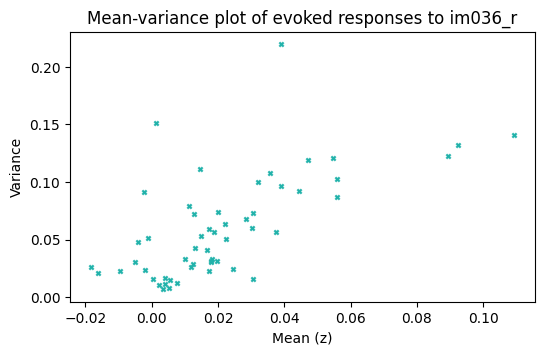

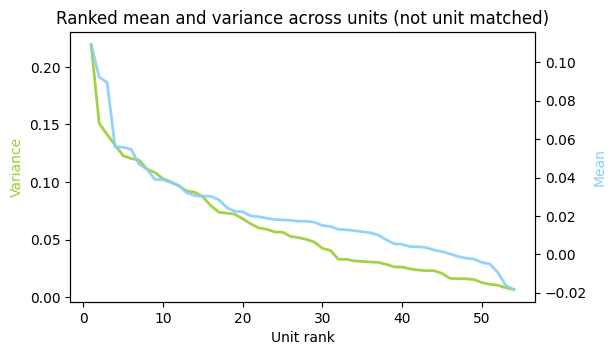

In [ ]:
baseline_window = [-0.25, 0]
baseline_window = np.array(baseline_window)

bsub = subtract_baseline(cube, baseline_window, bins)

zs, mu, std = zscore(bsub)
mu = np.squeeze(mu)
std = np.squeeze(std)

evoked_window = np.array([0, 0.25])
evoked_indices = np.searchsorted(bins, evoked_window)
means = mu[:, evoked_indices[0]:evoked_indices[1]].mean(axis=1)
variances = std[:, evoked_indices[0]:evoked_indices[1]].mean(axis=1) ** 2

fig, ax = plt.subplots(figsize=(6, 3.5))

ax.scatter(means, variances, s=15, c='lightseagreen', marker='X', linewidths=0.2)
ax.set_xlabel("Mean (z)")
ax.set_ylabel("Variance")
ax.set_title("Mean-variance plot of evoked responses to im036_r")

order_variances = np.argsort(variances)[::-1]
ranked_variances = variances[order_variances]
order_means = np.argsort(means)[::-1]
ranked_means = means[order_means]

x = np.arange(1, ranked_variances.size + 1)

fig1, ax1 = plt.subplots(figsize=(6, 3.5))
ax1.plot(x, ranked_variances, lw=2, alpha=0.9, color='yellowgreen')
ax1.set_xlabel("Unit rank")
ax1.set_ylabel("Variance")
ax1.yaxis.label.set_color('yellowgreen')

ax2 = ax1.twinx()
ax2.plot(x, ranked_means, lw=2, alpha=0.9, color='lightskyblue')
ax2.set_ylabel("Mean")
ax2.yaxis.label.set_color('lightskyblue')
ax1.set_title("Ranked mean and variance across units (not unit matched)")



 

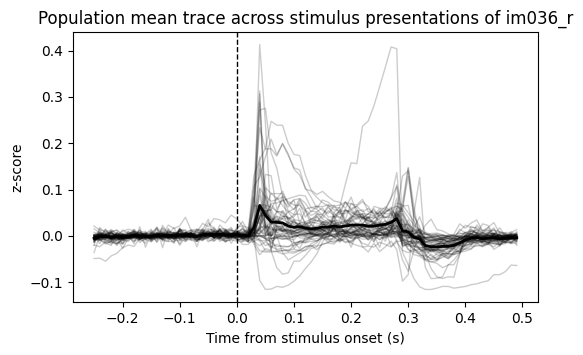

In [ ]:
fig1, ax1 = plot_pop_mean(mu, bins)

The next aim is to use a Receiver Operating Characteristic (ROC) curve to assess how discriminable single unit responses to each stimulus presentation are to one another.

In each instance, I will compare a PSTH trace from the ith repeat to the first repeat. Here there are two response distributions that are binned via the 10ms PSTH traces in my data structure:

R1 = (r1t1 + r1t2 + ... r1tn)
Ri = (rit1 + rit2 + ... ritn)

For a set of thresholds, any given threshold (Θ) is used to classify the response as either being from repeat 1 or repeat i. (e.g say if r > Θ, it is classified as being from repeat i, otherwise repeat 1).

Given that the distributions overlap, the decision will sometimes be right and sometimes be wrong. Therefore by performing the classification over the set of Θ values, it is possible to see how the trade-off between true positives and false positives changes.

Therefore, the AUC expresses the probability that a randomly chosen response from repeat i exceeds a randomly chosen response from repeat 1. Lets start with the first and second repeats.


In [ ]:
# pair = (zs[0,0,:], zs[0,2,:])

# fig, ax = plt.subplots(figsize=(6, 3.5))

# for unit_trace in pair:
#   ax.plot(bins, unit_trace, color='k', lw=1.0, zorder=1)

# ax.axvline(0, color='black', linestyle='--', linewidth=1)
# ax.set_xlabel("Time from stimulus onset (s)")
# ax.set_ylabel("z-score")


Comparing across 53 distributions
(54, 1064)


Text(0, 0.5, 'AUC')

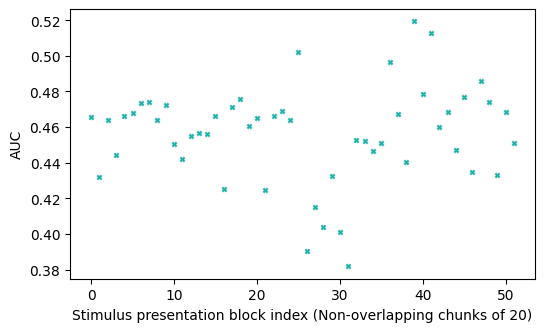

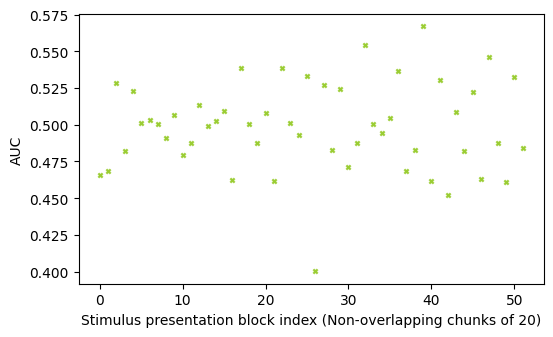

In [ ]:
def auc_between_dists(pair):

  dist1, dist2 = pair

  labels = np.concatenate([np.zeros_like(dist1), np.ones_like(dist2)])
  values = np.concatenate([dist1, dist2])
  auc = roc_auc_score(labels, values)
  return auc

n_units, n_repeats, _ = bsub.shape
n_dists = int(round(n_repeats / 20))
print(f"Comparing across {n_dists} distributions")

evoked_activity = bsub[:, :, evoked_indices[0]:evoked_indices[1]].mean(axis=2)
print(evoked_activity.shape)

dists = [evoked_activity[:, i*20:(i+1)*20] for i in range(n_dists)]

auc_vector_reference = np.zeros(n_dists-1)
auc_vector_consec = np.zeros(n_dists-1)

for i in range(len(dists)-1):
  pair = (dists[0], dists[i+1])
  auc_vector_reference[i] = auc_between_dists(pair)

for i in range(len(dists)-1):
  pair = (dists[i], dists[i+1])
  auc_vector_consec[i] = auc_between_dists(pair)

fig1, ax1 = plt.subplots(figsize=(6, 3.5))

ax1.scatter(list(range(len(auc_vector_reference))), auc_vector_reference, s=15, c='lightseagreen', marker='X', linewidths=0.2)
ax1.set_xlabel("Stimulus presentation block index (Non-overlapping chunks of 20)")
ax1.set_ylabel("AUC")

fig2, ax2 = plt.subplots(figsize=(6, 3.5))

ax2.scatter(list(range(len(auc_vector_consec))), auc_vector_consec, s=15, c='yellowgreen', marker='X', linewidths=0.2)
ax2.set_xlabel("Stimulus presentation block index (Non-overlapping chunks of 20)")
ax2.set_ylabel("AUC")

Text(0, 0.5, 'AUC')

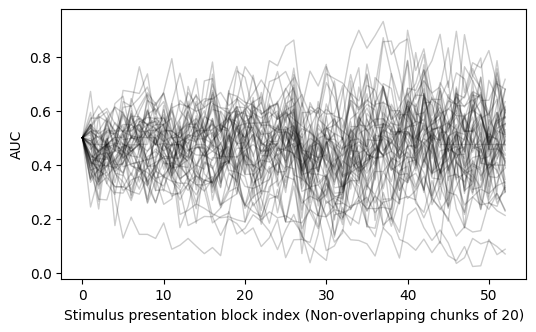

In [ ]:
dists_matrix = []

for u in range(n_units):
  unit_chunks = [evoked_activity[u, i*20:(i+1)*20] for i in range(n_dists)]
  dists_matrix.append(unit_chunks)

auc_matrix = []

for u in range(len(dists_matrix)):

  dists = dists_matrix[u]
  auc_vector = np.zeros(n_dists)

  for i in range(len(dists)):
    pair = (dists[0], dists[i])
    auc_vector[i] = auc_between_dists(pair)
  
  auc_matrix.append(auc_vector)

fig, ax = plt.subplots(figsize=(6, 3.5))

for u in range(len(dists_matrix)):
  ax.plot(list(range(n_dists)), auc_matrix[u], color='k', alpha=0.2, lw=1.0, zorder=1)

ax.set_xlabel("Stimulus presentation block index (Non-overlapping chunks of 20)")
ax.set_ylabel("AUC")
  